In [3]:
import numpy as np
import matplotlib.pyplot as plt

## Deterministic neoclassical growth (consumption-saving) model 

We solve a deterministic neoclassical growth (consumption-saving) model.

State: $k_t$ (current capital). Action: $k_{t+1}$ (next-period capital).

Output is $y_t = k_t^{\alpha}$, consumption is residual
$$
c_t = k_t^{\alpha} + (1-\delta)k_t - k_{t+1},\quad c_t>0,
$$
and period utility is $u(c_t)=\log c_t$.

The household solves
$$
\max_{\{k_{t+1}\}} \sum_{t=0}^{\infty} \beta^t \log(c_t).
$$


## Dynamic Programming (Value Iteration)

**Goal.** Compute the optimal saving rule in a deterministic neoclassical growth model via value function iteration.

**State, action.** Capital $k$ on a grid; action is next capital $k'$ on the same grid.

**Feasibility.**
$$
c = k^\alpha + (1-\delta)k - k' \ge 0,\qquad u(c)=\log(c).
$$

**Bellman equation.**
$$
V(k)=\max_{k'\in\mathcal K(k)} \left\{ u(c)+\beta V(k')\right\},\qquad \mathcal K(k)=\{k'\in[\underline{k},\overline{k}]: c\ge 0\}.
$$

**Value iteration (grid).**
- Precompute $c(k,k')$ and $u(c)$ (set $-\infty$ if $c\le 0$).
- Iterate $V^{(n+1)}(k)=\max_{k'}\{u(c)+\beta V^{(n)}(k')\}$ until convergence.
- Store the argmax as the policy $g(k)$.

In [4]:
def solve_growth_vi(
    alpha=0.36,
    beta=0.96,
    delta=0.08,
    k_min=1e-3,
    k_max=50.0,
    Nk=500,
    tol=1e-8,
    maxit=10_000,
    verbose=True
):
    """
    Deterministic consumption-saving (neoclassical growth) via value iteration.
    State: k
    Action: k' chosen directly on the same grid as k
    Consumption is residual: c = k^alpha + (1-delta)k - k'
    Utility: u(c)=log(c)
    """

    # --- Grids ---
    k_grid = np.linspace(k_min, k_max, Nk)

    # production
    y = k_grid ** alpha

    # utility with log(c); infeasible => -inf
    def u(c):
        out = np.full_like(c, -np.inf, dtype=float)
        mask = c > 0.0
        out[mask] = np.log(c[mask])
        return out

    # precompute consumption matrix c_{ij} for k_i (state) and k'_j (action)
    # c[i,j] = y(k_i) + (1-delta)k_i - k'_j
    resources = y + (1.0 - delta) * k_grid                      # shape (Nk,)
    c = resources[:, None] - k_grid[None, :]                    # shape (Nk, Nk)
    U = u(c)                                                    # shape (Nk, Nk)

    # value iteration
    V = np.zeros(Nk, dtype=float)
    pol_idx = np.zeros(Nk, dtype=int)

    for it in range(1, maxit + 1):
        # RHS(i,j) = U(i,j) + beta * V(j)  (since next state is exactly k'_j)
        rhs = U + beta * V[None, :]

        # Max over actions j for each state i
        V_new = np.max(rhs, axis=1)
        pol_idx_new = np.argmax(rhs, axis=1)

        diff = np.max(np.abs(V_new - V))
        V = V_new
        pol_idx = pol_idx_new

        if verbose and (it == 1 or it % 50 == 0 or diff < tol):
            print(f"VI iter {it:5d}: sup norm diff = {diff:.3e}")

        if diff < tol:
            break

    # Recover optimal policy and implied consumption
    kp_star = k_grid[pol_idx]
    c_star = resources - kp_star

    return k_grid, V, kp_star, c_star


In [10]:
alpha = 0.6
beta = 0.96
delta = 1.0 # closed form solution
delta = 1.0 # numerical solution

k_dp, V_dp, kp_star_dp, c_star_dp = solve_growth_vi(
    alpha=alpha, beta=beta, delta=delta,
    k_min=1e-3, k_max=5.0, Nk=500,
    tol=1e-8, maxit=10_000, verbose=True
)
    

VI iter     1: sup norm diff = 4.210e+00
VI iter    50: sup norm diff = 2.340e-01
VI iter   100: sup norm diff = 3.040e-02
VI iter   150: sup norm diff = 3.948e-03
VI iter   200: sup norm diff = 5.128e-04
VI iter   250: sup norm diff = 6.661e-05
VI iter   300: sup norm diff = 8.651e-06
VI iter   350: sup norm diff = 1.124e-06
VI iter   400: sup norm diff = 1.459e-07
VI iter   450: sup norm diff = 1.896e-08
VI iter   466: sup norm diff = 9.865e-09



Optimal policy in closed form: k' = (alpha*beta)*k^alpha


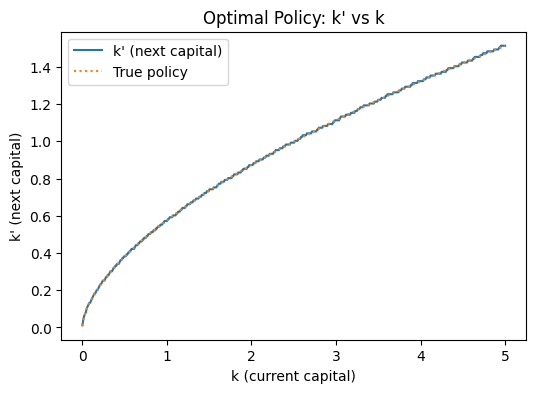

In [20]:
# the optimal policy in closed form for this model is k' = (1-alpha*beta)*k^alpha
print("\nOptimal policy in closed form: k' = (alpha*beta)*k^alpha")
optimal_kp = (alpha * beta) * k_dp ** alpha;

plt.figure(figsize=(6, 4))
plt.plot(k_dp, kp_star_dp, label="k' (next capital)")
plt.plot(k_dp, optimal_kp, label="True policy", linestyle=":")
plt.xlabel("k (current capital)")
plt.ylabel("k' (next capital)")
plt.title("Optimal Policy: k' vs k")
plt.legend()
plt.show()  

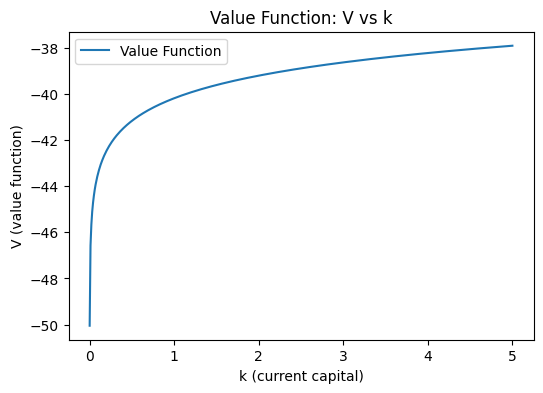

In [13]:
# Plot the value function

plt.figure(figsize=(6, 4))
plt.plot(k_dp, V_dp, label="Value Function")
plt.xlabel("k (current capital)")
plt.ylabel("V (value function)")
plt.title("Value Function: V vs k")
plt.legend()
plt.show()  

## Reinforcement learning (Q-learning)

**Goal.** Learn the saving rule with tabular Q-learning in the deterministic growth model.

**State, action.** State is capital $k$ on a grid; action is an investment fraction $\iota\in(0,1)$.

**Transition and reward.**
$$
k'=(1-\delta)k+\iota k^\alpha,\qquad c=(1-\iota)k^\alpha,\qquad r=\log(c).
$$

**Algorithm (minimal).**
- Precompute feasible actions and $(s,a)\to s'$ plus rewards on the grid.
- Use $\varepsilon$-greedy exploration and the TD update $Q(s,a)\leftarrow Q(s,a)+\alpha\,[r+\beta\max_{a'}Q(s',a')-Q(s,a)]$.
- Extract the greedy policy and implied $k'$ and $c$.

In [14]:
def q_learning_growth_investment_fraction(
    alpha=0.36,      # production exponent
    beta=0.96,       # discount factor
    delta=0.08,      # depreciation
    k_min=1e-3,
    k_max=20.0,
    Nk=400,          # number of capital grid points (states)
    Ni=101,          # number of investment-fraction grid points (actions)
    T=300,           # steps per episode
    episodes=50000,   # number of episodes
    eps=0.10,        # epsilon-greedy exploration
    lr=0.20,         # learning rate (constant; keep simple)
    c_floor=1e-12,   # avoid log(0)
    seed=0,
    verbose=True
):
    """
    Tabular Q-learning for deterministic growth model.

    State: k on a grid (index i)
    Action: investment fraction iota in (0,1) applied to production y=k^alpha:
            invest = iota * y
            consumption = (1 - iota) * y
            k' = (1-delta)k + invest

    Reward: log(consumption)
    Transition: project k' to nearest k-grid point.
    Feasible actions at a given k are those keeping k' within [k_min, k_max]
    and consumption > 0 (enforced by iota < 1).
    """

    rng = np.random.default_rng(seed)

    # --- grids ---
    k_grid = np.linspace(k_min, k_max, Nk)
    # investment fraction in (0,1): exclude endpoints to ensure c>0 and avoid trivialities
    iota_grid = np.linspace(0.0, 1.0, Ni)
    iota_grid = iota_grid[(iota_grid > 0.0) & (iota_grid < 1.0)]
    Ni = iota_grid.size

    # precompute y(k)
    y_grid = k_grid ** alpha

    # nearest-neighbor projection to k-grid index
    def proj_idx(kp):
        kp = np.clip(kp, k_min, k_max)
        j = np.searchsorted(k_grid, kp)
        j = np.clip(j, 1, Nk - 1)
        left = k_grid[j - 1]
        right = k_grid[j]
        return j if (kp - left) > (right - kp) else (j - 1)

    # precompute feasible actions per state + transition + reward tables
    # This keeps the learning loop minimal and fast.
    next_state = np.full((Nk, Ni), -1, dtype=int)
    reward = np.full((Nk, Ni), -np.inf, dtype=float)
    feasible_actions = []

    for s in range(Nk):
        k = k_grid[s]
        y = y_grid[s]

        feas = []
        for a in range(Ni):
            iota = iota_grid[a]
            c = (1.0 - iota) * y
            if c <= c_floor:
                continue

            kp = (1.0 - delta) * k + iota * y
            if (kp < k_min) or (kp > k_max):
                continue

            sp = proj_idx(kp)
            next_state[s, a] = sp
            reward[s, a] = np.log(c)
            feas.append(a)

        # If nothing feasible (rare if grids are sensible), allow a tiny-invest fallback
        if len(feas) == 0:
            # pick smallest iota that still yields c>0 and clip kp
            a = 0
            iota = iota_grid[a]
            c = max((1.0 - iota) * y, c_floor)
            kp = np.clip((1.0 - delta) * k + iota * y, k_min, k_max)
            sp = proj_idx(kp)
            next_state[s, a] = sp
            reward[s, a] = np.log(c)
            feas = [a]

        feasible_actions.append(np.array(feas, dtype=int))

    # --- Q table ---
    Q = np.zeros((Nk, Ni), dtype=float)

    # training
    for ep in range(1, episodes + 1):
        
        # random initial state (uniform on grid)
        s = int(rng.integers(0, Nk))

        for t in range(T):
            feas = feasible_actions[s]

            # epsilon-greedy over feasible actions only
            if rng.random() < eps:
                a = int(rng.choice(feas))
            else:
                a = int(feas[np.argmax(Q[s, feas])])

            sp = next_state[s, a]
            r = reward[s, a]

            # Q-learning update (deterministic transition)
            td_target = r + beta * np.max(Q[sp, feasible_actions[sp]])
            Q[s, a] += lr * (td_target - Q[s, a])

            s = sp

        if verbose and (ep == 1 or ep % 1000 == 0 or ep == episodes):
            # crude progress indicator: average greedy value proxy
            greedy_actions = np.array([feasible_actions[i][np.argmax(Q[i, feasible_actions[i]])] for i in range(Nk)])
            avg_r = np.mean([reward[i, greedy_actions[i]] for i in range(Nk)])
            print(f"Episode {ep:5d}/{episodes}: avg immediate reward under greedy policy ~ {avg_r:.4f}")

    # extract greedy policy
    pol_a = np.array([feasible_actions[s][np.argmax(Q[s, feasible_actions[s]])] for s in range(Nk)], dtype=int)
    iota_star = iota_grid[pol_a]

    # implied policy in k' and c
    k_star = k_grid
    y_star = y_grid
    c_star = (1.0 - iota_star) * y_star
    kp_star = (1.0 - delta) * k_star + iota_star * y_star

    return k_grid, Q, iota_star, c_star, kp_star


In [16]:
alpha = 0.6
beta = 0.96
delta = 1.0 # closed form solution

k_rl, Q_rl, iota_star_rl, c_star_rl, kp_star_rl = q_learning_growth_investment_fraction(
    alpha=alpha, beta=beta, delta=delta,
    k_min=1e-3, k_max=5.0, Nk=50, Ni=51,
    T=100, episodes=10_000,
    eps=0.10, lr=0.10,
    seed=0, verbose=True
)

Episode     1/10000: avg immediate reward under greedy policy ~ 0.2855
Episode  1000/10000: avg immediate reward under greedy policy ~ -0.4710
Episode  2000/10000: avg immediate reward under greedy policy ~ -0.9536
Episode  3000/10000: avg immediate reward under greedy policy ~ -1.2341
Episode  4000/10000: avg immediate reward under greedy policy ~ -1.2457
Episode  5000/10000: avg immediate reward under greedy policy ~ -1.1553
Episode  6000/10000: avg immediate reward under greedy policy ~ -0.8102
Episode  7000/10000: avg immediate reward under greedy policy ~ -1.0091
Episode  8000/10000: avg immediate reward under greedy policy ~ -0.8077
Episode  9000/10000: avg immediate reward under greedy policy ~ -0.9073
Episode 10000/10000: avg immediate reward under greedy policy ~ -0.9269


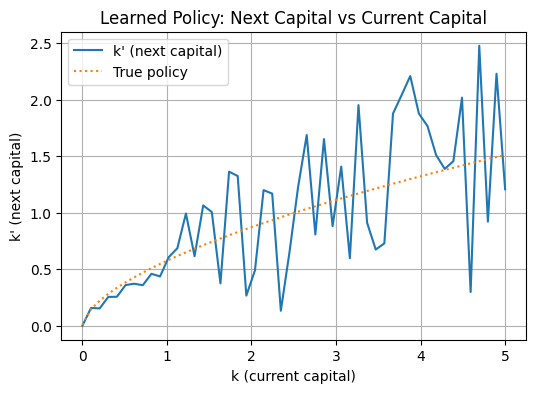

In [17]:
# compute closed form optimal policy for comparison: iota* = alpha*beta, c* = (1-iota)*y, k' = (1-delta)*k + iota*y
iota_star_closed = alpha * beta

y_grid = k_rl ** alpha
kp_star_closed = iota_star_closed * y_grid 
    
# Plot the policy
plt.figure(figsize=(6, 4))
plt.plot(k_rl, kp_star_rl, label="k' (next capital)")
plt.plot(k_rl, kp_star_closed, label="True policy", linestyle=":")
plt.xlabel("k (current capital)")
plt.ylabel("k' (next capital)")
plt.title("Learned Policy: Next Capital vs Current Capital")
plt.legend()
plt.grid()
plt.show()

In [18]:
# # plot value function (max Q) vs k
# feasible_actions = [np.where(Q_rl[s] > -np.inf)[0] for s in range(len(k_rl))]
# V_rl = np.array([np.max(Q_rl[s, feasible_actions[s]]) for s in range(len(k_rl))])

# plt.figure(figsize=(6, 4))
# plt.plot(k_rl, V_rl, label="RL Value Function (max Q)")
# plt.plot(k_dp, V_dp, label="DP Value Function", linestyle=":")
# plt.xlabel("k (current capital)")
# plt.ylabel("Value")
# plt.title("Value Function vs Current Capital")
# plt.legend()
# plt.grid()
# plt.show()  
